In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix

In [13]:
data_dir = os.path.join("M:", "neuro2voc", "task-5")
df_files = ['processed_spikes_0_20k.csv', 'processed_spikes_1_20k.csv', 'processed_spikes_2_20k.csv']
dfs = []

for file in df_files:
    df = pd.read_csv(os.path.join(data_dir, file))
    dfs.append(df)

df_0, df_1, df_2 = dfs

In [14]:
file_path = r"M:\neuro2voc\task-5\neural_data_0_30k.bin"

In [3]:
file_path = r"M:\neuro2voc\task-5\neural_data_1_30k.bin"

In [3]:
file_path = r"M:\neuro2voc\task-5\neural_data_2_30k.bin"

In [15]:
num_neurons = 75
data = np.fromfile(file_path, dtype=np.int16)
time_steps = data.size // num_neurons
data = data.reshape((num_neurons, time_steps))
print(f"Data shape: {data.shape}")
print(f"Data statistics: min={data.min()}, max={data.max()}, mean={data.mean()}")
print(f"Number of non-zero elements: {np.count_nonzero(data)}")

Data shape: (75, 95917689)
Data statistics: min=0, max=1, mean=0.0004612535372212036
Number of non-zero elements: 3318178


In [5]:
# memory constraint, only work one by one
# data_files = ['neural_data_0_30k.bin', 'neural_data_1_30k.bin', 'neural_data_2_30k.bin']
# data_list = []

# for file in data_files:
#     file_path = os.path.join(data_dir, file)
#     data = np.fromfile(file_path, dtype=np.int16)
#     time_steps = data.size // 75
#     data = data.reshape((75, time_steps))
#     data_list.append(data)

In [5]:
# Load and process annotations
annotation_files = ['annotations_raw_g0_t0.nidq.bin.csv', 'annotations_raw_g1_t0.nidq.bin.csv', 'annotations_raw_g2_t0.nidq.bin.csv']
filtered_dfs = []

for annotation_file in annotation_files:
    annotations_df = pd.read_csv(os.path.join(data_dir, annotation_file))
    annotations_df['onset'] = (annotations_df['onset']*1.5).astype(int)
    annotations_df['duration'] = (annotations_df['duration']*1.5).astype(int)
    filtered_df = annotations_df[annotations_df['cluster_id'].between(2, 8)]
    filtered_dfs.append(filtered_df)

filtered_df_0, filtered_df_1, filtered_df_2 = filtered_dfs
print(filtered_df_0.tail())
print(filtered_df_1.tail())
print(filtered_df_2.tail())

                   file     onset  duration  cluster_id
453  raw_g0_t0.nidq.bin  81194749      2287           4
454  raw_g0_t0.nidq.bin  81197037      3852           5
455  raw_g0_t0.nidq.bin  81201058       897           6
456  raw_g0_t0.nidq.bin  81202686      5844           7
457  raw_g0_t0.nidq.bin  81210043      5142           3
                   file      onset  duration  cluster_id
314  raw_g1_t0.nidq.bin  150072816      2179           4
315  raw_g1_t0.nidq.bin  150074998      3523           5
316  raw_g1_t0.nidq.bin  150078522      1380           6
317  raw_g1_t0.nidq.bin  150080608      5955           7
318  raw_g1_t0.nidq.bin  150103707      1992           2
                    file      onset  duration  cluster_id
2912  raw_g2_t0.nidq.bin  123520929       999           6
2913  raw_g2_t0.nidq.bin  123522883      5908           7
2914  raw_g2_t0.nidq.bin  123529807      4758           3
2915  raw_g2_t0.nidq.bin  123534565      2287           4
2916  raw_g2_t0.nidq.bin  123536

In [6]:
df = filtered_df_0

In [6]:
df = filtered_df_1

In [6]:
df = filtered_df_2

In [7]:
# Get last row's onset + duration
last_row = df.iloc[-1]
last_time = (last_row['onset'] + last_row['duration'])
print(f"Last time point: {last_time}")

# Trim data to last time point
trimmed_data = data[:, :last_time]
print(f"Original data shape: {data.shape}")
print(f"Trimmed data shape: {trimmed_data.shape}")

Last time point: 123540705
Original data shape: (75, 126659769)
Trimmed data shape: (75, 123540705)


# First Attempt, sample time

In [7]:
def extract_spike_data(df, annotation, before, after):
    onset = annotation['onset']
    start_time = onset - before * 20
    end_time = onset + after * 20
    
    # Filter spikes within the time window
    spikes = df[(df['time'] >= start_time) & (df['time'] < end_time)]
    
    # Create the output vector
    vector_size = int((before + after) * 20)
    output = np.zeros((75, vector_size), dtype=int)
    
    # Mark spikes
    for _, spike in spikes.iterrows():
        neuron = int(spike['reindex']) - 1
        if 0 <= neuron < 75:
            time_index = int(spike['time'] - start_time)
            if 0 <= time_index < vector_size:
                output[neuron, time_index] = 1
    
    return output

In [ ]:
before = 50  # 50ms before onset
after = 150   # 150ms after onset

# Process each annotation in filtered_df_0 (you can do the same for df_1 and df_2)
results = []

total_annotations = 10
with tqdm(total=total_annotations, desc="Processing annotations") as pbar:
    for _, annotation in filtered_df_0.iterrows():
        result = extract_spike_data(df_0, annotation, before, after)
        results.append(result)
        pbar.update(1)  # Update the progress bar
        

print(f"Processed {len(results)} annotations")
print(f"Shape of each result: {results[0].shape}")

Processing annotations:   7%|▋         | 28/417 [02:14<31:08,  4.80s/it]


MemoryError: Unable to allocate 2.24 GiB for an array with shape (75, 4000000) and data type float64

# Second Attempt, Binned

In [3]:
def process_single_syllable(data, annotation, bin_size, before_samples, end_early_samples=0, incomplete_bins=False):
    onset = annotation['onset']
    duration = annotation['duration']
    start = onset - before_samples
    end = onset + duration - end_early_samples
    
    relevant_data = data[:, start:end]
    total_samples = relevant_data.shape[1]
    num_complete_bins = total_samples // bin_size
    last_bin_size = total_samples % bin_size
    
    if incomplete_bins and last_bin_size > bin_size // 5:
        num_bins = num_complete_bins + 1
    else:
        num_bins = num_complete_bins
    
    binned_data = np.zeros((data.shape[0], num_bins))

    for i in range(num_complete_bins):
        bin_start = i * bin_size
        bin_end = (i + 1) * bin_size
        binned_data[:, i] = np.sum(relevant_data[:, bin_start:bin_end], axis=1)
    
    if num_bins > num_complete_bins:
        binned_data[:, -1] = np.sum(relevant_data[:, num_complete_bins*bin_size:], axis=1)
    
    return binned_data

In [6]:
def process_annotations(data, annotations_df, output_dir, original_fs=30000, target_fs=200, before_samples=1500, end_early_samples=0, incomplete_bins=False):
    data_dir = os.path.join(output_dir, "data")
    labels_dir = os.path.join(output_dir, "labels")
    os.makedirs(data_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    
    bin_size = original_fs // target_fs
    print(f"Target sample rate: {target_fs} Hz")
    print(f"Bin size: {bin_size}")
    assert target_fs * bin_size == original_fs
    print(f"Before samples: {before_samples} = {before_samples * (1000/original_fs)} ms")
    print(f"End early samples: {end_early_samples} = {end_early_samples * (1000/original_fs)} ms")
    # get largest existing index
    existing_data_files = glob.glob(os.path.join(data_dir, "*.npy"))
    existing_label_files = glob.glob(os.path.join(labels_dir, "*.npy"))
    if len(existing_data_files) != len(existing_label_files):
        raise ValueError("Mismatch between number of data and label files!")

    existing_indices = [int(os.path.basename(f).split('.')[0]) for f in existing_data_files + existing_label_files]
    print(f"{len(existing_data_files)} existing data files detected.")
    print(f"{len(existing_label_files)} existing label files detected.")

    start_index = max(existing_indices) + 1 if existing_indices else 0   
    print(f"Will continue indexing from {start_index:04d}")

    idx = 0

    for _, annotation in tqdm(annotations_df.iterrows(), total=len(annotations_df), desc="Processing..."):
        # data
        binned_data = process_single_syllable(data, annotation, bin_size, before_samples=before_samples, end_early_samples=end_early_samples, incomplete_bins=incomplete_bins)
        data_file = os.path.join(data_dir, f"{start_index + idx:04d}.npy")
        np.save(data_file, binned_data)
        
        # label
        label_file = os.path.join(labels_dir, f"{start_index + idx:04d}.npy")
        np.save(label_file, annotation['cluster_id'])
        idx += 1
    
    print(f"Processed {len(annotations_df)} new annotations.")
    print(f"Total number of files after processing: {start_index + len(annotations_df)}")

### choose target sampling rate
- 100Hz = 10ms per sample. For 10ms we have 10ms * (30000/1000) = 300 data
- 120Hz = 8.33ms per sample. For 8.33ms we have 8.33ms * (30000/1000) = 250 data
- 150Hz = 6.67ms per sample. For 6.67ms we have 6.67ms * (30000/1000) = 200 data
- 200Hz = 5ms per sample. For 5ms we have 5ms * (30000/1000) = 150 data	

### choose pre
- 1500 sample points = 1500 * (1000/30000) = 50ms


In [10]:
output_folder_name = "AOI_100hz_50ms_pre_end_bin"
output_dir = os.path.join(data_dir, output_folder_name)

process_annotations(data, df, output_dir, target_fs=100, before_samples=1500)

Target sample rate: 100 Hz
Bin size: 300
Before samples: 1500 = 50.0 ms
End early samples: 0 = 0.0 ms
608 existing data files detected.
608 existing label files detected.
Will continue indexing from 0608


Processing...: 100%|██████████| 2851/2851 [00:02<00:00, 1378.82it/s]

Processed 2851 new annotations.
Total number of files after processing: 3459


In [5]:
output_folder_name = "DTW_AOI_250hz_50ms_pre_50ms_endEarly_bin"
output_dir = os.path.join(data_dir, output_folder_name)

process_annotations(data, df, output_dir, target_fs=250, before_samples=1500, end_early_samples=1500, incomplete_bins=True)
# ratio of incomplete bins is hardcoded:     if incomplete_bins and last_bin_size > bin_size // 5:

NameError: name 'data' is not defined

# Third Attempt, Binned (actually last)
this time we do neural and vocal together
my vocal data is a spectrogram of 250Hz
I bin the same Hz

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.fftpack import dct

In [23]:
# neural data is already loaded
data.shape
print(f"Neural data shape: {data.shape}")

# spectrogram data
spectrogram_path = r"M:\neuro2voc\task-5\frequencies.spec.npy"
spec_dir = r"M:\neuro2voc\task-5\dtw\spectrogram"
spec_0 = np.load(f'{data_dir}\\raw_g0_t0.nidq.bin.spec.npy')
print(f"Spectrogram shape: {spec_0.shape}")

print(data.shape[1]/spec_0.shape[1]) # make sure neural and spectrogram assumptions are right
# here the result is 120 which means neural is 30k and spectrogram is 250

Neural data shape: (75, 95917689)
Spectrogram shape: (128, 799311)
120.000461647594


In [21]:
# Neural data shape: (75, 95917689)
# Spectrogram shape: (128, 799311)

# Load annotations
annotations_df_0 = pd.read_csv(f'{data_dir}\\annotations_raw_g0_t0.nidq.bin.csv')
filtered_df_0 = annotations_df_0[annotations_df_0['cluster_id'].between(2, 8)]

# Get first annotation for testing
test_annotation = filtered_df_0.iloc[0]
onset = test_annotation['onset']
duration = test_annotation['duration']

# Extract and bin neural data
# Convert from 20kHz to 250Hz (bin_size = 80)
bin_size = 80
before_samples = 1500  # 50ms at 20kHz
start = onset - before_samples
end = onset + duration

neural_segment = data[:, start:end]
num_bins = neural_segment.shape[1] // bin_size
binned_neural = np.zeros((data.shape[0], num_bins))

for i in range(num_bins):
    bin_start = i * bin_size
    bin_end = (i + 1) * bin_size
    binned_neural[:, i] = np.mean(neural_segment[:, bin_start:bin_end], axis=1)

# Extract corresponding spectrogram segment
# Convert onset/duration from 20kHz to 250Hz timebase
spec_start = int(start / 80)  # 20000/250 = 80
spec_end = int(end / 80)
spec_segment = spec_0[:, spec_start:spec_end]

print(f"\nFor annotation with onset={onset}, duration={duration}:")
print(f"Binned neural data shape: {binned_neural.shape}")
print(f"Spectrogram segment shape: {spec_segment.shape}")

# Visualize alignment
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

# Plot binned neural data
im1 = ax1.imshow(binned_neural, aspect='auto', interpolation='nearest')
ax1.set_title('Binned Neural Data')
plt.colorbar(im1, ax=ax1)

# Plot spectrogram segment  
im2 = ax2.imshow(spec_segment, aspect='auto', interpolation='nearest')
ax2.set_title('Spectrogram')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

Neural data shape: (75, 95917689)
Spectrogram shape: (128, 799311)


TypeError: slice indices must be integers or None or have an __index__ method

# Without annotation frame

In [8]:
def process_data(data, original_fs=30000, target_fs=200):
    bin_size = original_fs // target_fs
    print(f"Bin size: {bin_size}")
    
    total_samples = data.shape[1]
    num_bins = total_samples // bin_size

    print(f"Total number of bins: {num_bins}")

    binned_data = np.zeros((data.shape[0], num_bins))
    
    for i in tqdm(range(num_bins), desc="Processing bins"):
        bin_start = i * bin_size
        bin_end = (i + 1) * bin_size
        binned_data[:, i] = np.sum(data[:, bin_start:bin_end], axis=1)
    
    print(f"Processed data from {original_fs}Hz to {target_fs}Hz.")
    return binned_data

In [9]:
def save_data_chunks(data, output_dir, segment_length=50, overlap_ratio=1/3):
    data_dir = os.path.join(output_dir, "data")
    os.makedirs(data_dir, exist_ok=True)

    overlap_samples = int(segment_length * overlap_ratio)
    step = segment_length - overlap_samples

    num_segments = (data.shape[1] - overlap_samples) // step

    for i in tqdm(range(num_segments), desc="Saving segments"):
        start = i * step
        end = start + segment_length
        segment = data[:, start:end]
        
        segment_file = os.path.join(data_dir, f"segment_{i:06d}.npy")
        np.save(segment_file, segment)

    print(f"Saved {num_segments} segments in {data_dir}")

In [10]:
all_data_dir = "ALL_200hz_50_0.33_overlap_binned"
output_dir = os.path.join(data_dir, all_data_dir)

data = process_data(data, target_fs=1000)
save_data_chunks(data, output_dir, segment_length=20)


Bin size: 30
Total number of bins: 4221992


Processing bins: 100%|██████████| 4221992/4221992 [00:18<00:00, 228060.75it/s]


Processed data from 30000Hz to 1000Hz.


Saving segments: 100%|██████████| 301570/301570 [01:19<00:00, 3817.22it/s]

Saved 301570 segments in M:neuro2voc\task-5\ALL_200hz_50_0.33_overlap_binned\data


# Last try All time sample time data with labels

In [8]:
annotation_df = pd.read_csv(os.path.join(data_dir, annotation_file))
# Convert from 20kHz to 100Hz by dividing by 200
annotation_df['onset'] = (annotation_df['onset']/200).astype(int)
annotation_df['duration'] = (annotation_df['duration']/200).astype(int)
filtered_df = annotation_df[annotation_df['cluster_id'].between(2, 8)]
print(annotation_df.iloc[2798:2800])

                    file   onset  duration  cluster_id
2798  raw_g2_t0.nidq.bin  309945         6           4
2799  raw_g2_t0.nidq.bin  309952        12           5


In [9]:
# Sort the dataframe by onset to ensure chronological order
sorted_df = filtered_df.sort_values('onset').copy()  # Create copy to avoid modifying original

# Initialize variables to track overlaps
overlaps_found = []

# Check each consecutive pair of rows and fix overlaps
for i in range(len(sorted_df)-1):
    current_end = sorted_df.iloc[i]['onset'] + sorted_df.iloc[i]['duration']
    next_start = sorted_df.iloc[i+1]['onset']
    
    if current_end > next_start:
        overlap_size = current_end - next_start
        print(f"Found overlap between rows {sorted_df.index[i]} and {sorted_df.index[i+1]}")
        print(f"First annotation ends at {current_end}, but next starts at {next_start}")
        print(f"Overlap size: {overlap_size} samples")
        
        # Calculate midpoint of overlap
        overlap_midpoint = next_start + (overlap_size // 2)
        
        # Adjust both annotations to meet at midpoint
        sorted_df.iloc[i, sorted_df.columns.get_loc('duration')] = overlap_midpoint - sorted_df.iloc[i]['onset']
        
        # Adjust start of next annotation and its duration
        duration_adjustment = overlap_midpoint - next_start
        sorted_df.iloc[i+1, sorted_df.columns.get_loc('onset')] = overlap_midpoint
        sorted_df.iloc[i+1, sorted_df.columns.get_loc('duration')] -= duration_adjustment
        
        overlaps_found.append((sorted_df.index[i], sorted_df.index[i+1], overlap_size))

if not overlaps_found:
    print("No overlaps found between consecutive annotations")
else:
    print(f"\nFound and fixed {len(overlaps_found)} overlaps")
    print("Summary of overlaps fixed:")
    for first_idx, second_idx, overlap_size in overlaps_found:
        print(f"Between annotations {first_idx} and {second_idx}: {overlap_size} samples")


Found overlap between rows 141 and 142
First annotation ends at 13544, but next starts at 13543
Overlap size: 1 samples
Found overlap between rows 380 and 381
First annotation ends at 45007, but next starts at 45006
Overlap size: 1 samples
Found overlap between rows 434 and 435
First annotation ends at 52308, but next starts at 52307
Overlap size: 1 samples
Found overlap between rows 457 and 458
First annotation ends at 56966, but next starts at 56965
Overlap size: 1 samples
Found overlap between rows 479 and 480
First annotation ends at 57306, but next starts at 57305
Overlap size: 1 samples
Found overlap between rows 500 and 501
First annotation ends at 58264, but next starts at 58262
Overlap size: 2 samples
Found overlap between rows 539 and 540
First annotation ends at 59864, but next starts at 59863
Overlap size: 1 samples
Found overlap between rows 646 and 647
First annotation ends at 69809, but next starts at 69807
Overlap size: 2 samples
Found overlap between rows 651 and 652
F

In [10]:
# Create a copy of the original dataframe
df_with_gaps = sorted_df.copy()

# Get the last row's end time
last_end = df_with_gaps.iloc[-1]['onset'] + df_with_gaps.iloc[-1]['duration']

# Get the first row's start time
first_start = df_with_gaps.iloc[0]['onset']

# Add row at the beginning if needed
if first_start > 0:
    start_row = pd.DataFrame({
        'onset': [0],
        'duration': [first_start],
        'cluster_id': [9]
    })
    df_with_gaps = pd.concat([start_row, df_with_gaps]).reset_index(drop=True)

# Add rows between gaps
for i in range(len(sorted_df)-1):
    current_end = sorted_df.iloc[i]['onset'] + sorted_df.iloc[i]['duration']
    next_start = sorted_df.iloc[i+1]['onset']
    
    if current_end < next_start:
        gap_row = pd.DataFrame({
            'onset': [current_end],
            'duration': [next_start - current_end],
            'cluster_id': [9]
        })
        # Insert the gap row after the current row
        df_with_gaps = pd.concat([
            df_with_gaps.iloc[:i+1], 
            gap_row,
            df_with_gaps.iloc[i+1:]
        ]).reset_index(drop=True)

# Add row at the end if needed
if last_end < len(data[0]):  # Assuming data is your full dataset
    end_row = pd.DataFrame({
        'onset': [last_end],
        'duration': [len(data[0]) - last_end],
        'cluster_id': [9]
    })
    df_with_gaps = pd.concat([df_with_gaps, end_row]).reset_index(drop=True)

# Sort by onset again to ensure proper ordering
df_with_gaps = df_with_gaps.sort_values('onset').reset_index(drop=True)


In [11]:
# Check for duplicates in df_with_gaps
duplicates = df_with_gaps[df_with_gaps.duplicated(['onset', 'duration'], keep=False)]
if not duplicates.empty:
    print("Found duplicate rows:")
    print(duplicates)
    # Remove duplicates, keeping first occurrence
    df_with_gaps = df_with_gaps.drop_duplicates(['onset', 'duration'], keep='first')
else:
    print("No duplicate rows found")

# Verify no overlaps remain
overlaps_found = False
for i in range(len(df_with_gaps)-1):
    current_end = df_with_gaps.iloc[i]['onset'] + df_with_gaps.iloc[i]['duration']
    next_start = df_with_gaps.iloc[i+1]['onset']
    
    if current_end > next_start:
        print(f"Overlap found between rows {i} and {i+1}")
        print(f"First annotation ends at {current_end}, but next starts at {next_start}")
        overlaps_found = True

if not overlaps_found:
    print("No overlaps found between consecutive annotations")


No duplicate rows found
No overlaps found between consecutive annotations


In [12]:
df_with_gaps

,onset,duration,cluster_id,file
0,0,3273,9,NaN
1,3273,5,2,raw_g2_t0.nidq.bin
2,3278,15,9,NaN
3,3293,5,2,raw_g2_t0.nidq.bin
4,3298,9,9,NaN
...,...,...,...,...
5143,411766,15,3,raw_g2_t0.nidq.bin
5144,411781,7,4,raw_g2_t0.nidq.bin
5145,411788,1,9,NaN
5146,411789,12,5,raw_g2_t0.nidq.bin


In [15]:
def process_data(data, original_fs=30000, target_fs=100):
    # Calculate bin size based on sampling rates
    bin_size = original_fs // target_fs
    
    # Get total number of samples and calculate number of complete bins
    total_samples = data.shape[1]
    num_bins = total_samples // bin_size
    
    # Initialize output array
    binned_data = np.zeros((data.shape[0], num_bins))
    
    # Process each bin
    for i in tqdm(range(num_bins), desc="Processing bins"):
        bin_start = i * bin_size
        bin_end = (i + 1) * bin_size
        # Take mean instead of sum to preserve scale
        binned_data[:, i] = np.mean(data[:, bin_start:bin_end], axis=1)
    
    return binned_data

In [19]:
# Process the data
processed_data = process_data(trimmed_data, original_fs=30000, target_fs=100)

# Create labels array matching the processed data length
labels = np.zeros(processed_data.shape[1], dtype=int)
# Fill labels based on onset and duration
for _, row in df_with_gaps.iterrows():
    onset = row['onset']
    duration = row['duration'] 
    cluster_id = row['cluster_id']
    # Assign cluster_id to all timepoints in this segment
    labels[onset:onset+duration] = int(cluster_id)


Processing bins: 100%|██████████| 411802/411802 [00:08<00:00, 48246.28it/s]


In [20]:
np.unique(labels)

array([2, 3, 4, 5, 6, 7, 8, 9])

In [21]:
# Save data and print shapes
cebra_dir = r"M:\neuro2voc\task-5\cebra"
os.makedirs(cebra_dir, exist_ok=True)

print(f"Processed data shape: {processed_data.shape}")
print(f"Labels shape: {labels.shape}")

np.save(os.path.join(cebra_dir, "processed_data_3.npy"), processed_data)
np.save(os.path.join(cebra_dir, "labels_3.npy"), labels)

Processed data shape: (75, 411802)
Labels shape: (411802,)


# TF-IDF

In [7]:
def extract_annotation_data(data, annotation):
    onset = annotation['onset']
    duration = annotation['duration']
    return data[:, onset:onset+duration]

In [8]:
def calculate_tfidf(data, annotations_df):
    # Prepare data for TF-IDF calculation
    documents = []
    
    for _, annotation in tqdm(annotations_df.iterrows(), total=len(annotations_df), desc="Processing annotations"):
        annotation_data = extract_annotation_data(data, annotation)
        # Sum across time dimension to get total activations for each neuron
        # neuron_activations = np.sum(annotation_data, axis=1)\
        neuron_activations = np.mean(annotation_data, axis=1)
        documents.append(neuron_activations)
    
    # Stack the documents into a 2D array
    documents_array = np.vstack(documents)
    
    # Convert to sparse matrix
    documents_sparse = csr_matrix(documents_array)
    
    # Calculate TF-IDF
    tfidf_transformer = TfidfTransformer()
    tfidf_matrix = tfidf_transformer.fit_transform(documents_sparse)
    
    # Convert to dense matrix for easier handling
    tfidf_dense = tfidf_matrix.toarray()
    
    return tfidf_dense

In [9]:
tfidf_results = calculate_tfidf(data, df)

Processing annotations: 100%|██████████| 2851/2851 [00:00<00:00, 5040.37it/s]


In [10]:
print("TF-IDF shape:", tfidf_results.shape)

TF-IDF shape: (2851, 75)


In [11]:
labels = df['cluster_id'].values
print("labels shape:", labels.shape)

labels shape: (2851,)


In [12]:
output_csv_name = 'tf-idf-2.csv'

In [13]:
tfidf_df = pd.DataFrame(tfidf_results)
tfidf_df['label'] = labels

output_folder_name = "tf-idf-data-labels"
output_dir = os.path.join(data_dir, output_folder_name)
os.makedirs(output_dir, exist_ok=True)

output_file = os.path.join(output_dir, output_csv_name)
tfidf_df.to_csv(output_file, index=False)

print(f"Data saved as CSV file: {output_file}")

Data saved as CSV file: M:neuro2voc\task-5\tf-idf-data-labels\tf-idf-2.csv


In [39]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_results, labels, test_size=0.2, random_state=42)

In [40]:
svm_pipeline = make_pipeline(StandardScaler(), SVC(kernel='rbf', random_state=42))

# Perform cross-validation
cv_scores = cross_val_score(svm_pipeline, X_train, y_train, cv=5)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

# Train the model on the entire training set
svm_pipeline.fit(X_train, y_train)

# Evaluate on the test set
test_score = svm_pipeline.score(X_test, y_test)
print("Test set accuracy:", test_score)

# If you want to see predictions on the test set
y_pred = svm_pipeline.predict(X_test)
print("First few predictions:", y_pred[:10])
print("First few true labels:", y_test[:10])

# Optionally, you can save the model
from joblib import dump
dump(svm_pipeline, 'svm_model.joblib')

Cross-validation scores: [0.80597015 0.7761194  0.7761194  0.72727273 0.8030303 ]
Mean CV score: 0.7777023971053822
Test set accuracy: 0.7619047619047619
First few predictions: [3 6 3 6 5 7 7 5 5 6]
First few true labels: [3 6 3 6 5 7 7 5 7 6]


['svm_model.joblib']

# Then, downsampling and DTW to neural data

In [7]:
import os
import numpy as np
from collections import defaultdict
from scipy import interpolate
from dtaidistance import dtw_ndim
from tqdm import tqdm

In [8]:
def warp_data(data, reference_data):
    path = dtw_ndim.warping_path(data.T, reference_data.T)
    
    # Group path by target indices (j) and average source indices (i)
    grouped = defaultdict(list)
    for i, j in path:
        grouped[j].append(i)
    
    # Sort the target indices
    sorted_j = sorted(grouped.keys())
    
    # Ensure strictly increasing source indices by averaging
    source_indices = []
    target_indices = []
    last_i = -1
    for j in sorted_j:
        i_list = grouped[j]
        avg_i = int(np.mean(i_list))
        if avg_i > last_i:
            source_indices.append(avg_i)
            target_indices.append(j)
            last_i = avg_i
        else:
            # Adjust to ensure strict increase
            avg_i = max(last_i + 1, avg_i)
            source_indices.append(avg_i)
            target_indices.append(j)
            last_i = avg_i
    
    source_indices = np.array(source_indices)
    target_indices = np.array(target_indices)
    
    # Ensure source_indices are within bounds
    source_indices = np.clip(source_indices, 0, data.shape[1] - 1)
    
    # Interpolation function for each channel
    warped_data = np.zeros((data.shape[0], reference_data.shape[1]))
    
    for channel in range(data.shape[0]):
        f = interpolate.interp1d(
            source_indices, 
            data[channel, source_indices], 
            kind='linear', 
            bounds_error=False, 
            fill_value='extrapolate'
        )
        warped_channel = f(np.arange(reference_data.shape[1]))
        warped_data[channel, :] = warped_channel
    
    return warped_data

In [9]:
data_dir = r"M:\neuro2voc\task-5\DTW_AOI_250hz_50ms_pre_50ms_endEarly_bin\data"
labels_dir = r"M:\neuro2voc\task-5\DTW_AOI_250hz_50ms_pre_50ms_endEarly_bin\labels"

data_files = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])
label_files = sorted([f for f in os.listdir(labels_dir) if f.endswith('.npy')])

label_groups = defaultdict(list)

for data_file, label_file in zip(data_files, label_files):
    data_path = os.path.join(data_dir, data_file)
    label_path = os.path.join(labels_dir, label_file)
    
    data = np.load(data_path)
    label = np.load(label_path)
    
    if 2 <= label <= 8:
        label_groups[int(label)].append(data)

In [10]:
# # Check the contents of label_groups dictionary
# for label, data_list in label_groups.items():
#     print(f"Label {label}: {len(data_list)} samples")
#     print(f"  Sample shape: {data_list[0].shape}")
#     print(f"  Data type: {data_list[0].dtype}")
#     print()

# # Print total number of samples
# total_samples = sum(len(data_list) for data_list in label_groups.values())
# print(f"Total number of samples: {total_samples}")

# # Check a few samples from each label group
# for label, data_list in label_groups.items():
#     print(f"Label {label}:")
#     for i, data in enumerate(data_list[:3]):  # Check first 3 samples of each label
#         print(f"  Sample {i}:")
#         print(f"    Shape: {data.shape}")
#         print(f"    Non-zero elements: {np.count_nonzero(data)}")
#         print(f"    Min: {data.min()}, Max: {data.max()}, Mean: {data.mean():.4f}")
#     print()

In [24]:
from collections import defaultdict

warped_data = defaultdict(list)
warped_labels = defaultdict(list)

for label, data_list in tqdm(label_groups.items(), desc="Processing groups"):
    longest_length = max(data.shape[1] for data in data_list)
    print(f"Label {label}, longest length: {longest_length}")
    reference_data = next(data for data in data_list if data.shape[1] == longest_length)
    
    for data in data_list:
        if data.shape[1] < longest_length:
            # Interpolate to the same length as the reference data
            x = np.linspace(0, 1, data.shape[1])
            x_new = np.linspace(0, 1, longest_length)
            interpolated_data = np.array([np.interp(x_new, x, channel) for channel in data])
            # Apply DTW warping
            try:
                warped = warp_data(interpolated_data, reference_data)
                warped_data[label].append(warped)
                warped_labels[label].append(label)
            except Exception as e:
                print(f"Error processing label {label}: {e}")
        else:
            # Already longest, no need for interpolation or warping
            warped_data[label].append(data)
            warped_labels[label].append(label)

for label in warped_data:
    warped_data[label] = np.array(warped_data[label])
    warped_labels[label] = np.array(warped_labels[label])

for label in warped_data:
    print(f"Label {label}: {len(warped_data[label])} samples, Shape: {warped_data[label].shape}")

print(f"Unique labels: {np.unique(list(warped_labels.keys()))}")

Processing groups:   0%|          | 0/7 [00:00<?, ?it/s]

Label 2, longest length: 26


Processing groups:  14%|█▍        | 1/7 [00:02<00:14,  2.39s/it]

Label 3, longest length: 44


Processing groups:  29%|██▊       | 2/7 [00:08<00:22,  4.45s/it]

Label 4, longest length: 20


In [23]:
warped_data_concatenated = np.concatenate(warped_data, axis=1)
warped_labels_concatenated = np.concatenate(warped_labels)

warped_data_dir = r"M:\neuro2voc\task-5\DTW_AOI_250hz_50ms_pre_50ms_endEarly_bin"
np.save(os.path.join(warped_data_dir, "warped_data.npy"), warped_data_concatenated)
np.save(os.path.join(warped_data_dir, "warped_labels.npy"), warped_labels_concatenated)
print("Successfully saved the data and labels to", warped_data_dir)

Label 2 shape: (472, 75, 26)
Label 3 shape: (638, 75, 44)
Label 4 shape: (626, 75, 20)
Label 5 shape: (623, 75, 43)
Label 6 shape: (541, 75, 15)
Label 7 shape: (554, 75, 56)
Label 8 shape: (5, 75, 30)
Maximum length: 56
Concatenated warped data shape: (3459, 75, 56)
Concatenated warped labels shape: (3459,)
Successfully saved the data and labels to M:\neuro2voc\task-5\DTW_AOI_250hz_50ms_pre_50ms_endEarly_bin
Loaded warped data shape: (3459, 75, 56)
Loaded warped labels shape: (3459,)
Unique labels in loaded data: [2 3 4 5 6 7 8]


In [16]:
# # Load the saved data
# warped_data_dir = r"M:\neuro2voc\task-5\archived-datasets\archived_DTW_AOI_50ms_pre_250hz_50ms_endEarly_bin"
# warped_data_concatenated = np.load(os.path.join(warped_data_dir, "warped_data.npy"))
# warped_labels_concatenated = np.load(os.path.join(warped_data_dir, "warped_labels.npy"))

# print("Loaded warped_data_concatenated shape:", warped_data_concatenated.shape)
# print("Loaded warped_labels_concatenated shape:", warped_labels_concatenated.shape)

Loaded warped_data_concatenated shape: (75, 118942)
Loaded warped_labels_concatenated shape: (118942,)


### PCA 1

In [17]:
from sklearn.decomposition import PCA
import os
import numpy as np
from tqdm import tqdm

neural_pca_dir = r"M:\neuro2voc\task-5\dtw\neural"
os.makedirs(neural_pca_dir, exist_ok=True)

for label, data_list in tqdm(group_warped_data.items(), desc="Processing groups for PCA"):
    if label < 2 or label > 8:
        continue  # Skip labels outside the 2-8 range
    
    # Stack neural data (each row is now a full neural sequence)
    stacked_neural_data = np.vstack(data_list)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(stacked_neural_data)
    
    # Save PCA components and results
    np.save(os.path.join(neural_pca_dir, f"pca_components_label_{label}.npy"), pca.components_)
    
    print(f"Completed PCA for label {label}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Shape of PCA components: {pca.components_.shape}")

print("PCA processing complete.")

NameError: name 'group_warped_data' is not defined

### PCA 2

In [79]:
from sklearn.decomposition import PCA
import os
import numpy as np
from tqdm import tqdm

# Directory to save PCA results
pca_dir = r"M:\neuro2voc\task-5\dtw\pca_results"
os.makedirs(pca_dir, exist_ok=True)

for label, data in tqdm(warped_data.items(), desc="Processing groups for PCA"):
    if label < 2 or label > 8:
        continue  # Skip labels outside the 2-8 range
    
    # Reshape the data to 2D: (n_samples, n_features)
    n_samples, n_channels, n_timepoints = data.shape
    reshaped_data = data.reshape(n_samples, n_channels * n_timepoints)
    
    # Perform PCA
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(reshaped_data)
    
    # Save PCA results
    np.save(os.path.join(pca_dir, f"pca_result_label_{label}.npy"), pca_result)
    np.save(os.path.join(pca_dir, f"pca_components_label_{label}.npy"), pca.components_)
    
    print(f"Completed PCA for label {label}")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Shape of PCA result: {pca_result.shape}")
    print(f"Shape of PCA components: {pca.components_.shape}")

print("PCA processing complete.")

Processing groups for PCA: 100%|██████████| 7/7 [00:00<00:00, 63.59it/s]

Completed PCA for label 2
Explained variance ratio: [0.0229935 0.0200303]
Shape of PCA result: (472, 2)
Shape of PCA components: (2, 1950)
Completed PCA for label 3
Explained variance ratio: [0.01243815 0.00795426]
Shape of PCA result: (638, 2)
Shape of PCA components: (2, 3300)
Completed PCA for label 4
Explained variance ratio: [0.01686728 0.01134006]
Shape of PCA result: (626, 2)
Shape of PCA components: (2, 1500)
Completed PCA for label 5
Explained variance ratio: [0.01260734 0.01149886]
Shape of PCA result: (623, 2)
Shape of PCA components: (2, 3225)
Completed PCA for label 6
Explained variance ratio: [0.02220333 0.01568479]
Shape of PCA result: (541, 2)
Shape of PCA components: (2, 1125)
Completed PCA for label 7
Explained variance ratio: [0.01290443 0.00831723]
Shape of PCA result: (554, 2)
Shape of PCA components: (2, 4200)
Completed PCA for label 8
Explained variance ratio: [0.32116565 0.25361368]
Shape of PCA result: (5, 2)
Shape of PCA components: (2, 2250)
PCA processing co

# Match PCA

In [25]:
import numpy as np
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt
from itertools import product


Label 2:
Shape of neural PCA data: (2, 26)
Shape of MFCC PCA data: (2, 26)
Neural PCA data - Min: -0.15, Max: 0.65, Mean: 0.10
MFCC PCA data - Min: -0.19, Max: 0.30, Mean: 0.10
Best combination: (0, 0, 0, 0)
Best mutual information score: 1.4791

Label 3:
Shape of neural PCA data: (2, 44)
Shape of MFCC PCA data: (2, 44)
Neural PCA data - Min: -0.13, Max: 0.88, Mean: 0.08
MFCC PCA data - Min: -0.23, Max: 0.28, Mean: 0.08
Best combination: (0, 1, 0, 0)
Best mutual information score: 1.7665

Label 4:
Shape of neural PCA data: (2, 20)
Shape of MFCC PCA data: (2, 20)
Neural PCA data - Min: -0.18, Max: 0.74, Mean: 0.11
MFCC PCA data - Min: -0.21, Max: 0.42, Mean: 0.11
Best combination: (0, 0, 0, 0)
Best mutual information score: 2.1116

Label 5:
Shape of neural PCA data: (2, 43)
Shape of MFCC PCA data: (2, 43)
Neural PCA data - Min: -0.19, Max: 0.37, Mean: 0.08
MFCC PCA data - Min: -0.25, Max: 0.42, Mean: 0.08
Best combination: (1, 0, 0, 0)
Best mutual information score: 1.8298

Label 6:
Sh

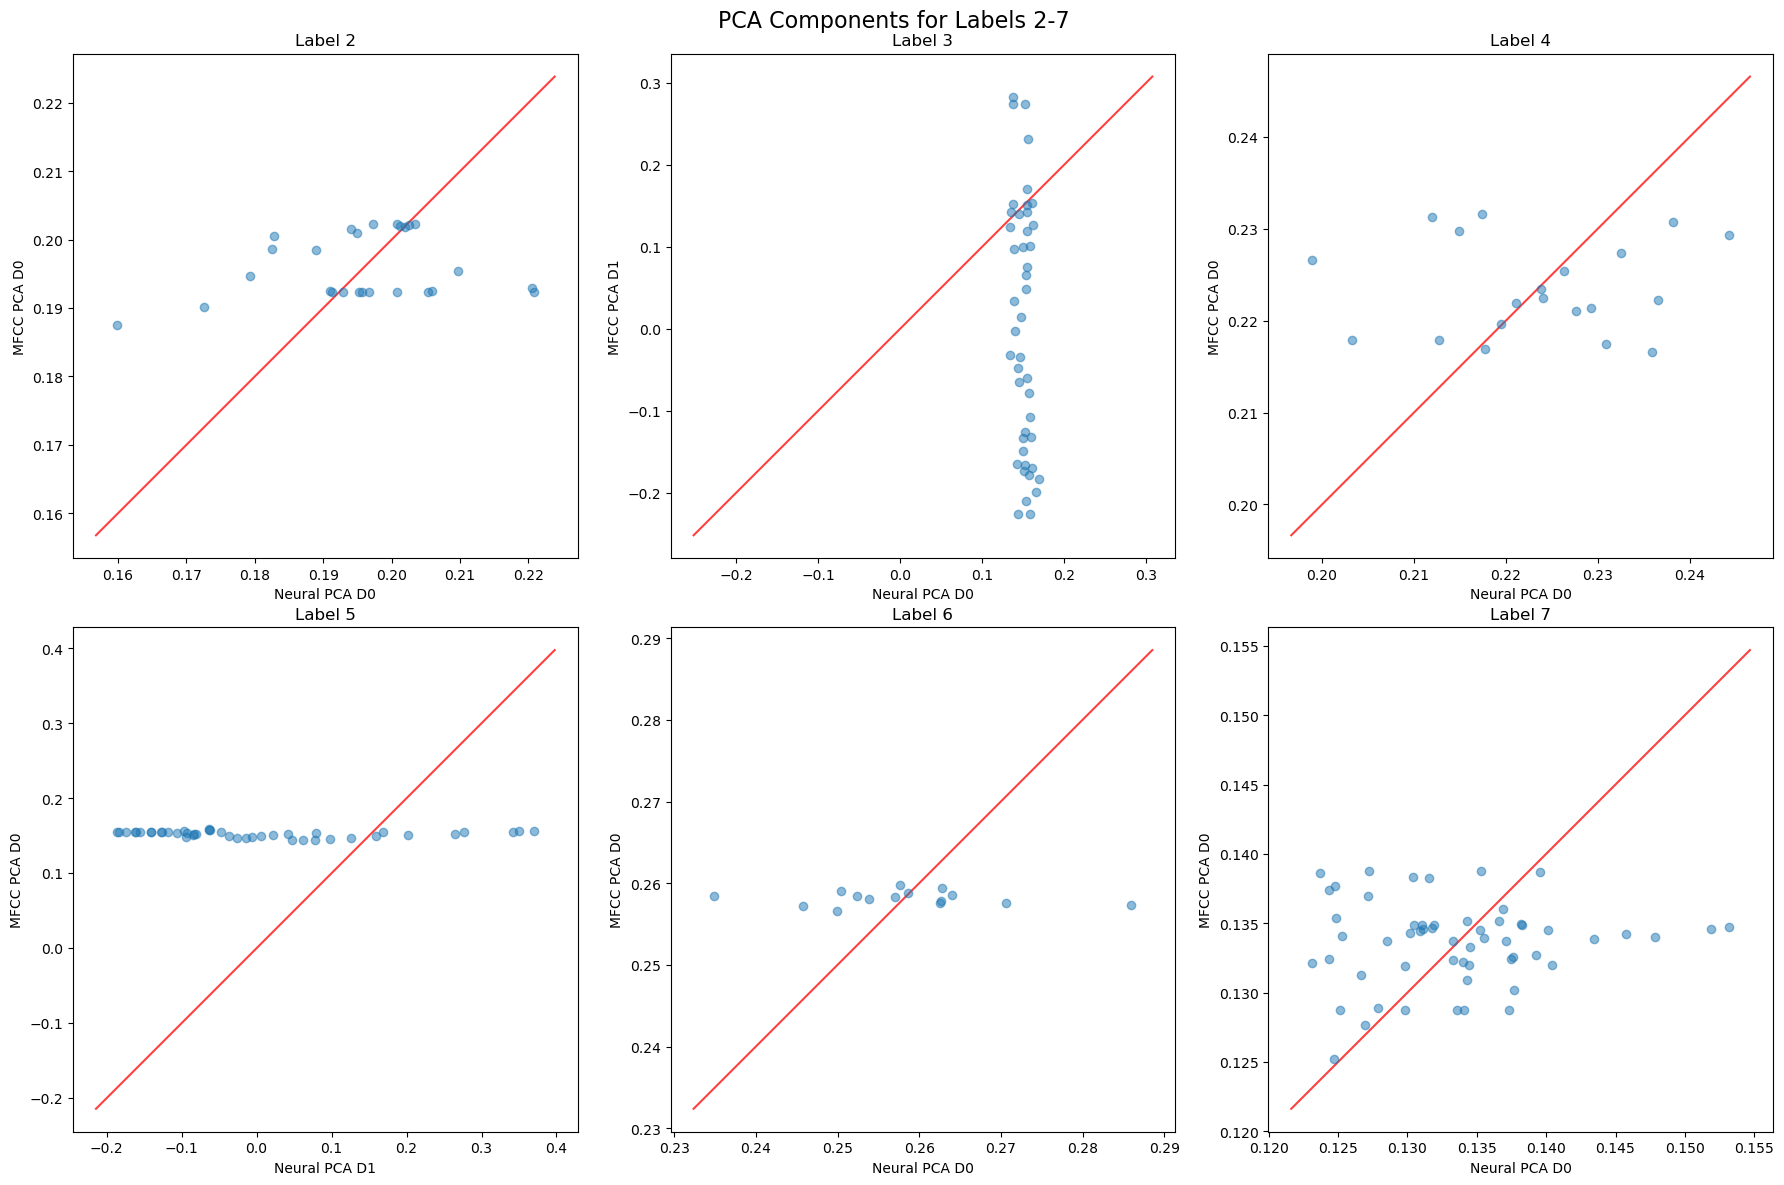

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn.metrics import mutual_info_score

def calculate_mi(x, y, bins=20):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("PCA Components for Labels 2-7", fontsize=16)

for i, label in enumerate(range(2, 8)):
    neural_pca_path = fr"M:\neuro2voc\task-5\dtw\neural\pca_components_label_{label}.npy"
    mfcc_pca_path = fr"M:\neuro2voc\task-5\dtw\PCA-MFCC\pca_components_label_{label}.npy"

    # Read the numpy arrays
    neural_pca = np.load(neural_pca_path)
    mfcc_pca = np.load(mfcc_pca_path)

    print(f"\nLabel {label}:")
    print(f"Shape of neural PCA data: {neural_pca.shape}")
    print(f"Shape of MFCC PCA data: {mfcc_pca.shape}")
    print(f"Neural PCA data - Min: {neural_pca.min():.2f}, Max: {neural_pca.max():.2f}, Mean: {neural_pca.mean():.2f}")
    print(f"MFCC PCA data - Min: {mfcc_pca.min():.2f}, Max: {mfcc_pca.max():.2f}, Mean: {mfcc_pca.mean():.2f}")

    # Generate all possible combinations
    combinations = list(product(range(2), repeat=4))

    # Calculate mutual information for each combination
    mi_scores = []
    for combo in combinations:
        neural_dim = combo[0]
        mfcc_dim = combo[1]
        neural_data = neural_pca[neural_dim]
        mfcc_data = mfcc_pca[mfcc_dim]
        mi = calculate_mi(neural_data, mfcc_data)
        mi_scores.append((combo, mi))

    # Sort combinations by mutual information score
    mi_scores.sort(key=lambda x: x[1], reverse=True)

    # Get the best combination
    best_combo, best_mi = mi_scores[0]

    print(f"Best combination: {best_combo}")
    print(f"Best mutual information score: {best_mi:.4f}")

    # Plot the best combination
    neural_dim, mfcc_dim = best_combo[0], best_combo[1]
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    
    # Make the plot square
    ax.set_aspect('equal', 'box')
    
    # Plot the scatter points
    ax.scatter(neural_pca[neural_dim], mfcc_pca[mfcc_dim], alpha=0.5)
    
    # Add diagonal red line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    
    ax.set_xlabel(f"Neural PCA D{neural_dim}")
    ax.set_ylabel(f"MFCC PCA D{mfcc_dim}")
    ax.set_title(f"Label {label}")

plt.tight_layout()
plt.show()



Label 2:
Shape of neural PCA data: (2, 26)
Shape of MFCC PCA data: (2, 26)
Neural PCA data - Min: -0.15, Max: 0.65, Mean: 0.10
MFCC PCA data - Min: -0.19, Max: 0.30, Mean: 0.10

Label 3:
Shape of neural PCA data: (2, 44)
Shape of MFCC PCA data: (2, 44)
Neural PCA data - Min: -0.13, Max: 0.88, Mean: 0.08
MFCC PCA data - Min: -0.23, Max: 0.28, Mean: 0.08

Label 4:
Shape of neural PCA data: (2, 20)
Shape of MFCC PCA data: (2, 20)
Neural PCA data - Min: -0.18, Max: 0.74, Mean: 0.11
MFCC PCA data - Min: -0.21, Max: 0.42, Mean: 0.11

Label 5:
Shape of neural PCA data: (2, 43)
Shape of MFCC PCA data: (2, 43)
Neural PCA data - Min: -0.19, Max: 0.37, Mean: 0.08
MFCC PCA data - Min: -0.25, Max: 0.42, Mean: 0.08

Label 6:
Shape of neural PCA data: (2, 15)
Shape of MFCC PCA data: (2, 15)
Neural PCA data - Min: -0.22, Max: 0.65, Mean: 0.12
MFCC PCA data - Min: -0.22, Max: 0.53, Mean: 0.13

Label 7:
Shape of neural PCA data: (2, 56)
Shape of MFCC PCA data: (2, 56)
Neural PCA data - Min: -0.17, Max:

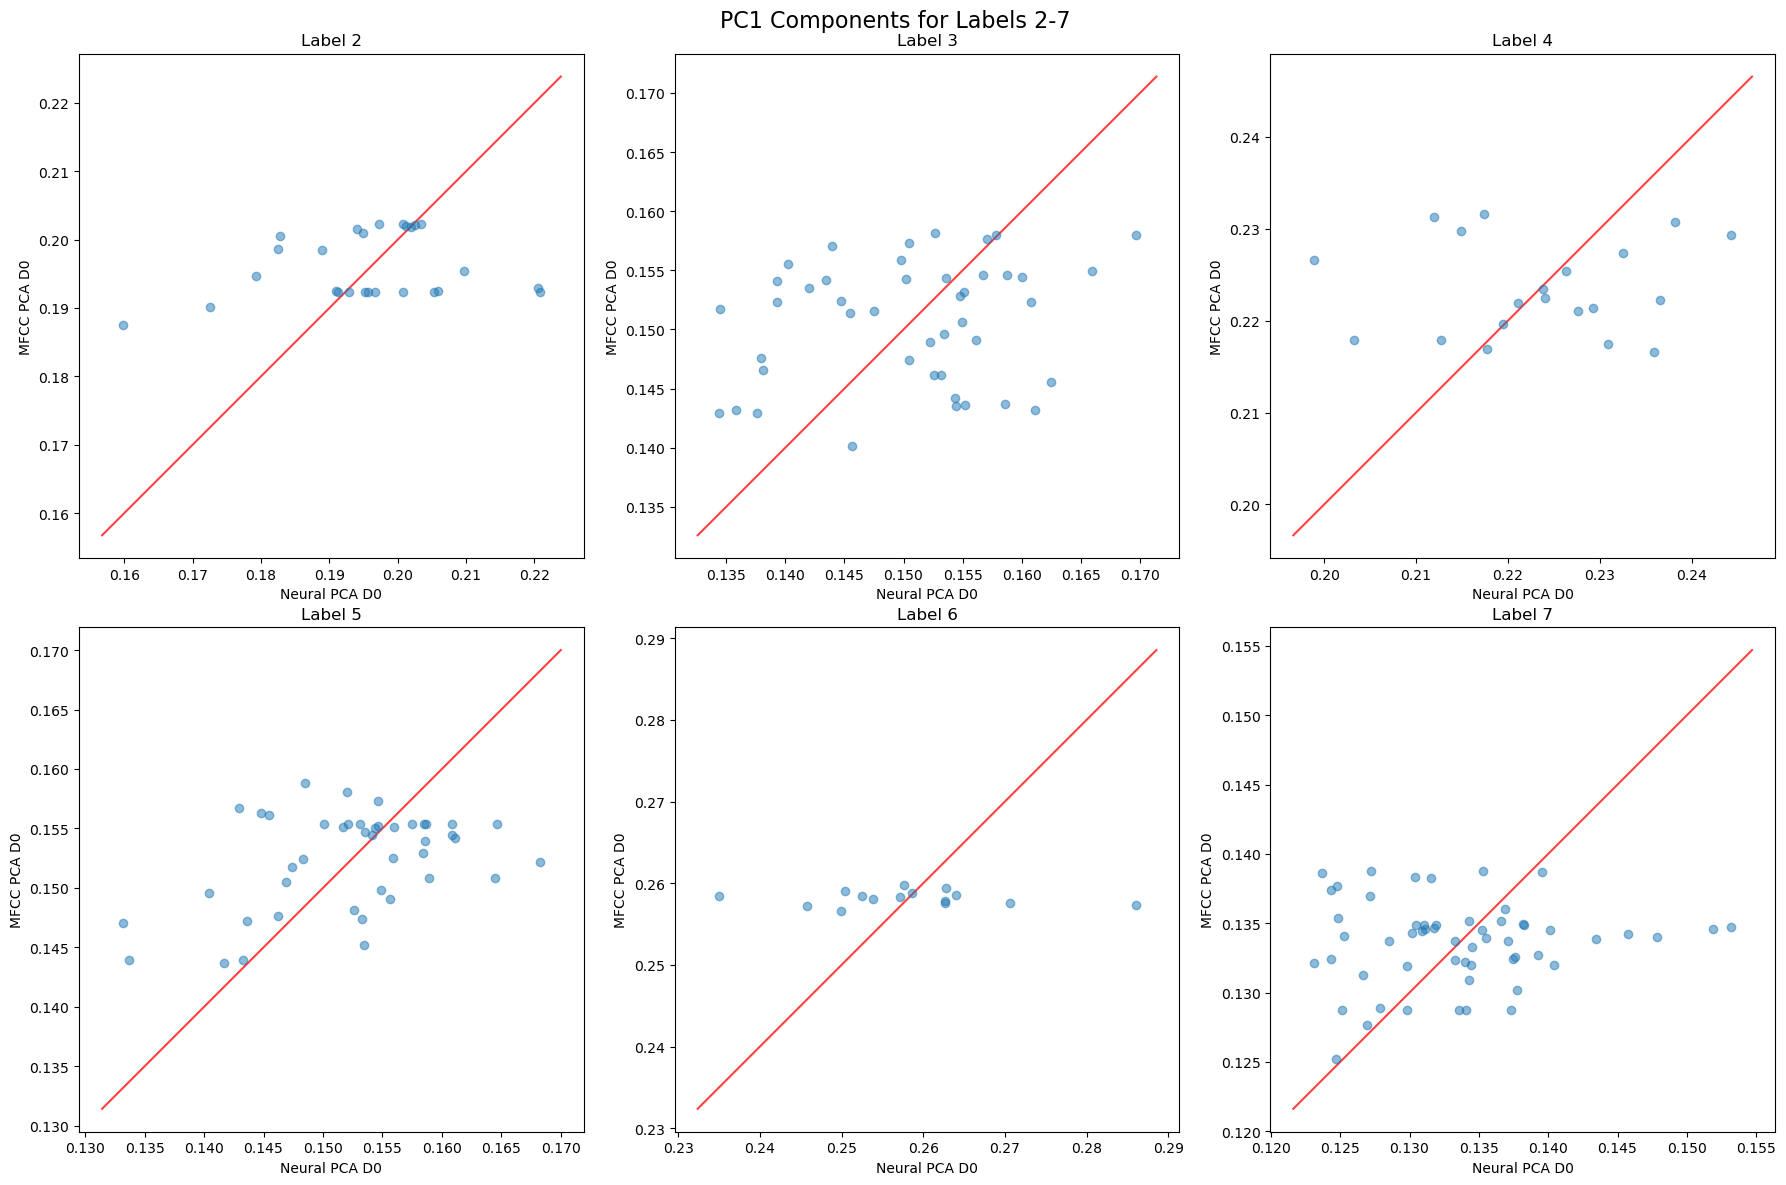

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# always dimension 0 no MI
# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("PC1 Components for Labels 2-7", fontsize=16)

for i, label in enumerate(range(2, 8)):
    neural_pca_path = fr"M:\neuro2voc\task-5\dtw\neural\pca_components_label_{label}.npy"
    mfcc_pca_path = fr"M:\neuro2voc\task-5\dtw\PCA-MFCC\pca_components_label_{label}.npy"

    # Read the numpy arrays
    neural_pca = np.load(neural_pca_path)
    mfcc_pca = np.load(mfcc_pca_path)

    print(f"\nLabel {label}:")
    print(f"Shape of neural PCA data: {neural_pca.shape}")
    print(f"Shape of MFCC PCA data: {mfcc_pca.shape}")
    print(f"Neural PCA data - Min: {neural_pca.min():.2f}, Max: {neural_pca.max():.2f}, Mean: {neural_pca.mean():.2f}")
    print(f"MFCC PCA data - Min: {mfcc_pca.min():.2f}, Max: {mfcc_pca.max():.2f}, Mean: {mfcc_pca.mean():.2f}")

    # Plot dimension 0 of neural PCA vs dimension 0 of MFCC PCA
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    
    # Make the plot square
    ax.set_aspect('equal', 'box')
    
    # Plot the scatter points
    ax.scatter(neural_pca[0], mfcc_pca[0], alpha=0.5)
    
    # Add diagonal red line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    
    ax.set_xlabel("Neural PCA D0")
    ax.set_ylabel("MFCC PCA D0")
    ax.set_title(f"Label {label}")

plt.tight_layout()
plt.show()



Label 2:
Shape of neural PCA data: (2, 26)
Shape of MFCC PCA data: (2, 26)
Neural PCA data - Min: -0.15, Max: 0.65, Mean: 0.10
MFCC PCA data - Min: -0.19, Max: 0.30, Mean: 0.10

Label 3:
Shape of neural PCA data: (2, 44)
Shape of MFCC PCA data: (2, 44)
Neural PCA data - Min: -0.13, Max: 0.88, Mean: 0.08
MFCC PCA data - Min: -0.23, Max: 0.28, Mean: 0.08

Label 4:
Shape of neural PCA data: (2, 20)
Shape of MFCC PCA data: (2, 20)
Neural PCA data - Min: -0.18, Max: 0.74, Mean: 0.11
MFCC PCA data - Min: -0.21, Max: 0.42, Mean: 0.11

Label 5:
Shape of neural PCA data: (2, 43)
Shape of MFCC PCA data: (2, 43)
Neural PCA data - Min: -0.19, Max: 0.37, Mean: 0.08
MFCC PCA data - Min: -0.25, Max: 0.42, Mean: 0.08

Label 6:
Shape of neural PCA data: (2, 15)
Shape of MFCC PCA data: (2, 15)
Neural PCA data - Min: -0.22, Max: 0.65, Mean: 0.12
MFCC PCA data - Min: -0.22, Max: 0.53, Mean: 0.13

Label 7:
Shape of neural PCA data: (2, 56)
Shape of MFCC PCA data: (2, 56)
Neural PCA data - Min: -0.17, Max:

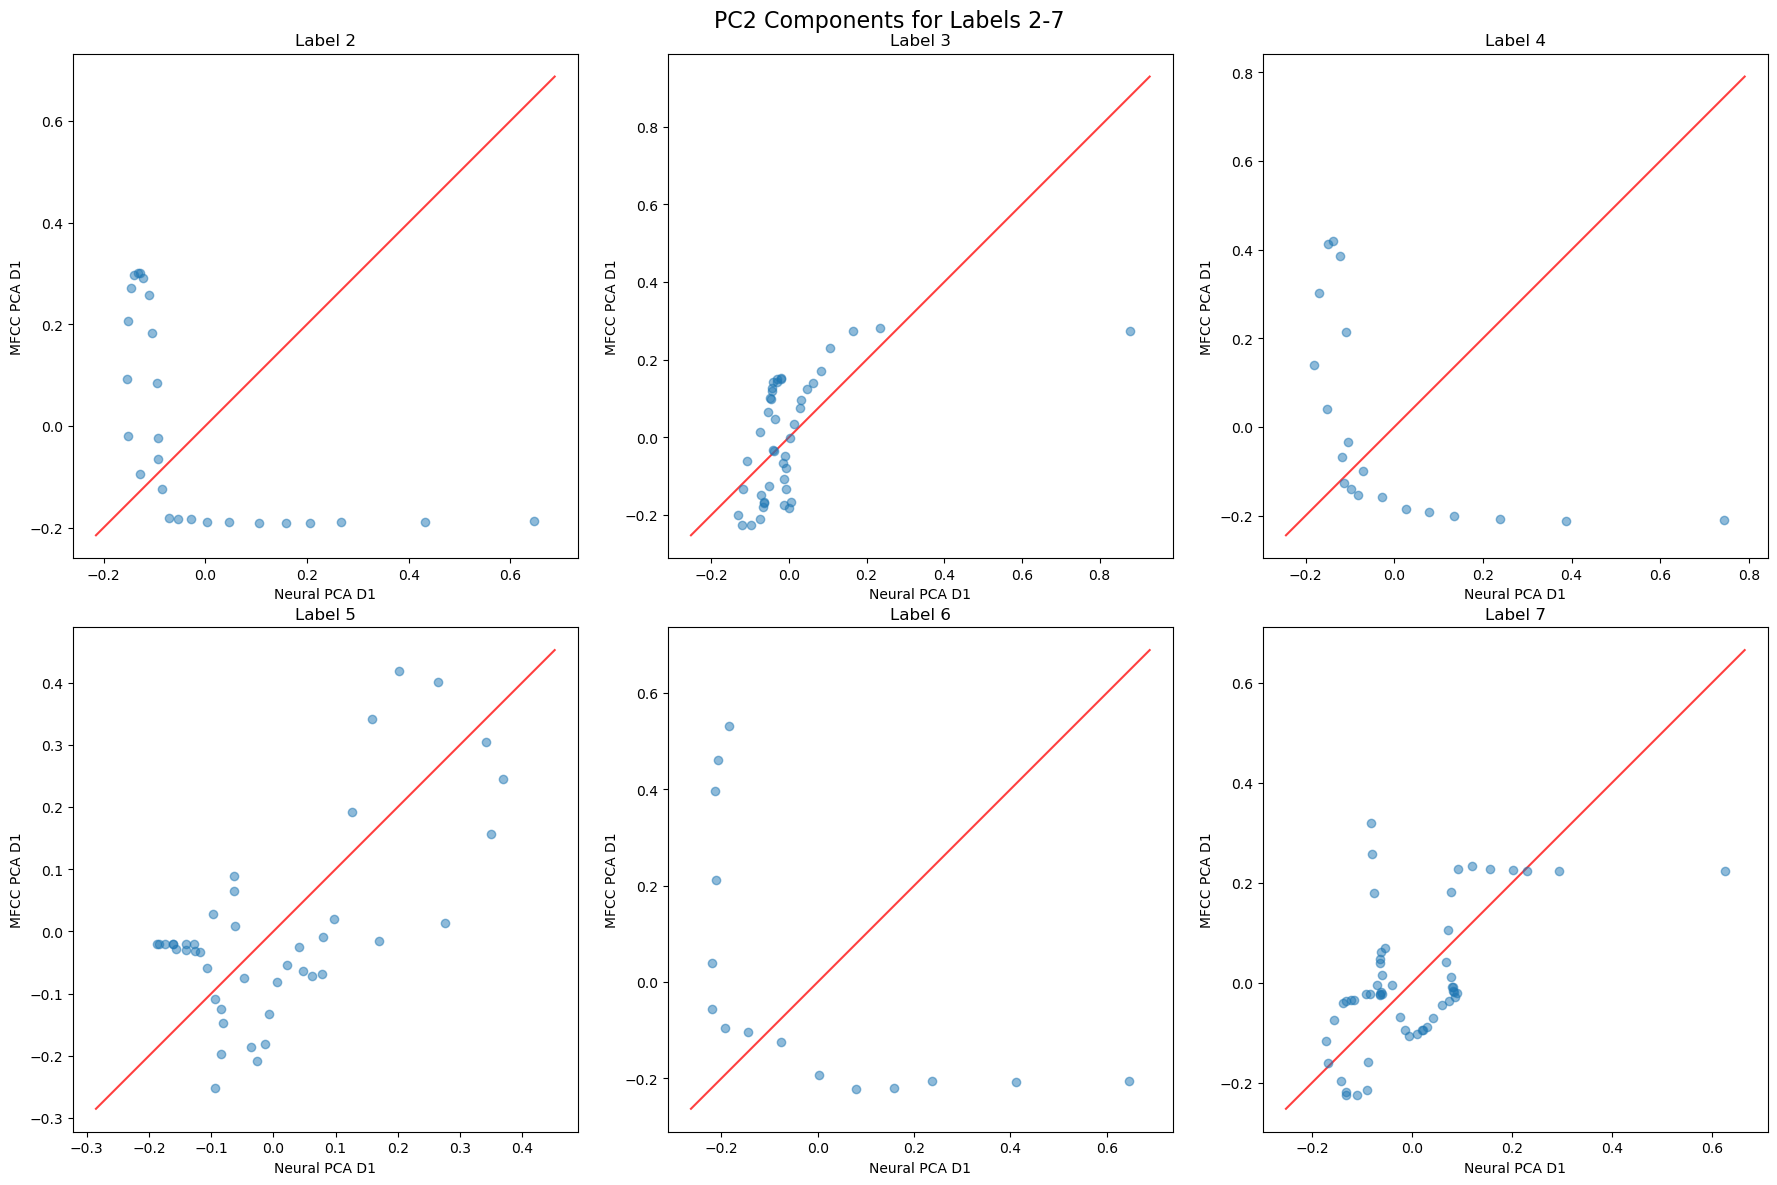

In [54]:
import numpy as np
import matplotlib.pyplot as plt

# Create a 2x3 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("PC2 Components for Labels 2-7", fontsize=16)

for i, label in enumerate(range(2, 8)):
    neural_pca_path = fr"M:\neuro2voc\task-5\dtw\neural\pca_components_label_{label}.npy"
    mfcc_pca_path = fr"M:\neuro2voc\task-5\dtw\PCA-MFCC\pca_components_label_{label}.npy"

    # Read the numpy arrays
    neural_pca = np.load(neural_pca_path)
    mfcc_pca = np.load(mfcc_pca_path)

    print(f"\nLabel {label}:")
    print(f"Shape of neural PCA data: {neural_pca.shape}")
    print(f"Shape of MFCC PCA data: {mfcc_pca.shape}")
    print(f"Neural PCA data - Min: {neural_pca.min():.2f}, Max: {neural_pca.max():.2f}, Mean: {neural_pca.mean():.2f}")
    print(f"MFCC PCA data - Min: {mfcc_pca.min():.2f}, Max: {mfcc_pca.max():.2f}, Mean: {mfcc_pca.mean():.2f}")

    # Plot dimension 1 of neural PCA vs dimension 1 of MFCC PCA
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    
    # Make the plot square
    ax.set_aspect('equal', 'box')
    
    # Plot the scatter points
    ax.scatter(neural_pca[1], mfcc_pca[1], alpha=0.5)
    
    # Add diagonal red line
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    ax.plot(lims, lims, 'r-', alpha=0.75, zorder=0)
    
    ax.set_xlabel("Neural PCA D1")
    ax.set_ylabel("MFCC PCA D1")
    ax.set_title(f"Label {label}")

plt.tight_layout()
plt.show()


In [45]:
neural_pca_path = r"M:\neuro2voc\task-5\dtw\neural\pca_components_label_4.npy"
mfcc_pca_path = r"M:\neuro2voc\task-5\dtw\PCA-MFCC\pca_components_label_4.npy"

# Read the numpy arrays
neural_pca = np.load(neural_pca_path)
mfcc_pca = np.load(mfcc_pca_path)

print(f"Shape of neural PCA data: {neural_pca.shape}")
print(f"Shape of MFCC PCA data: {mfcc_pca.shape}")
print(f"\nNeural PCA data - Min: {neural_pca.min()}, Max: {neural_pca.max()}, Mean: {neural_pca.mean()}")
print(f"MFCC PCA data - Min: {mfcc_pca.min()}, Max: {mfcc_pca.max()}, Mean: {mfcc_pca.mean()}")

Shape of neural PCA data: (2, 20)
Shape of MFCC PCA data: (2, 20)

Neural PCA data - Min: -0.18090318299806346, Max: 0.7442839809247641, Mean: 0.11086578815941164
MFCC PCA data - Min: -0.21290849671720743, Max: 0.4204235235939249, Mean: 0.10995111301405211



Best combination: (0, 0, 0, 0)
Best mutual information score: 2.1116308425056016


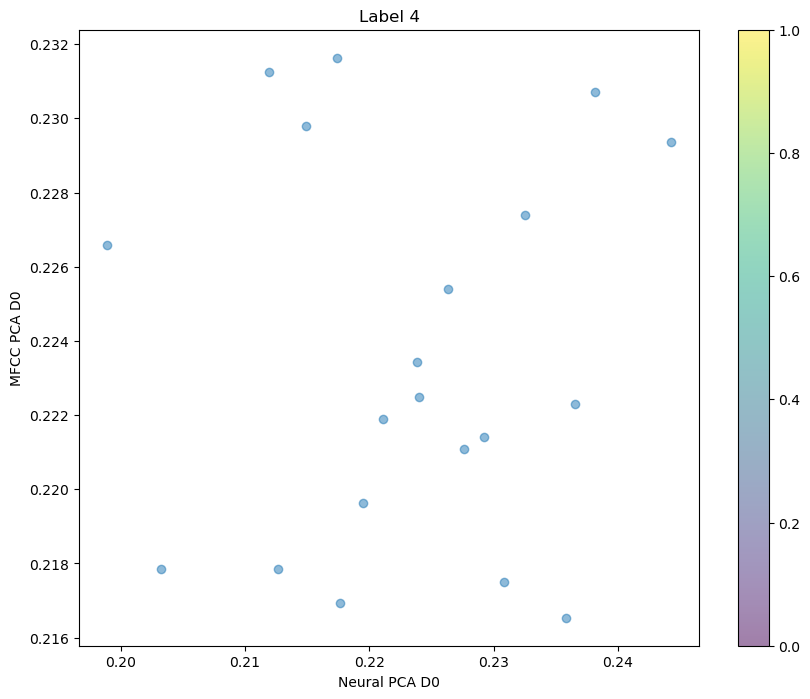

In [43]:
def calculate_mi(x, y, bins=20):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

# Generate all possible combinations
combinations = list(product(range(2), repeat=4))

# Calculate mutual information for each combination
mi_scores = []
for combo in combinations:
    neural_dim = combo[0]
    mfcc_dim = combo[1]
    neural_data = neural_pca[neural_dim]
    mfcc_data = mfcc_pca[mfcc_dim]
    mi = calculate_mi(neural_data, mfcc_data)
    mi_scores.append((combo, mi))

# Sort combinations by mutual information score
mi_scores.sort(key=lambda x: x[1], reverse=True)

# Get the best combination
best_combo, best_mi = mi_scores[0]

print(f"\nBest combination: {best_combo}")
print(f"Best mutual information score: {best_mi}")

# Plot the best combination
neural_dim, mfcc_dim = best_combo[0], best_combo[1]
plt.figure(figsize=(10, 8))
plt.scatter(neural_pca[neural_dim], mfcc_pca[mfcc_dim], alpha=0.5)
plt.xlabel(f"Neural PCA D{neural_dim}")
plt.ylabel(f"MFCC PCA D{mfcc_dim}")
plt.title(f"Label 4")
plt.colorbar()
plt.show()
